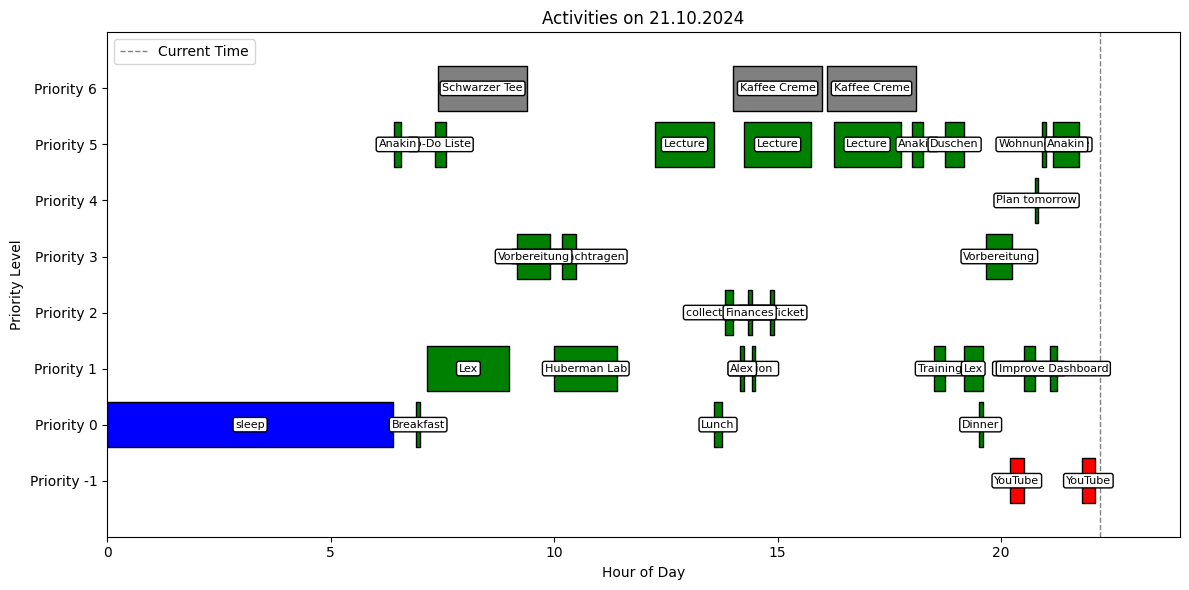

In [22]:
plot_activities_of_a_day(plot_today, today_str)

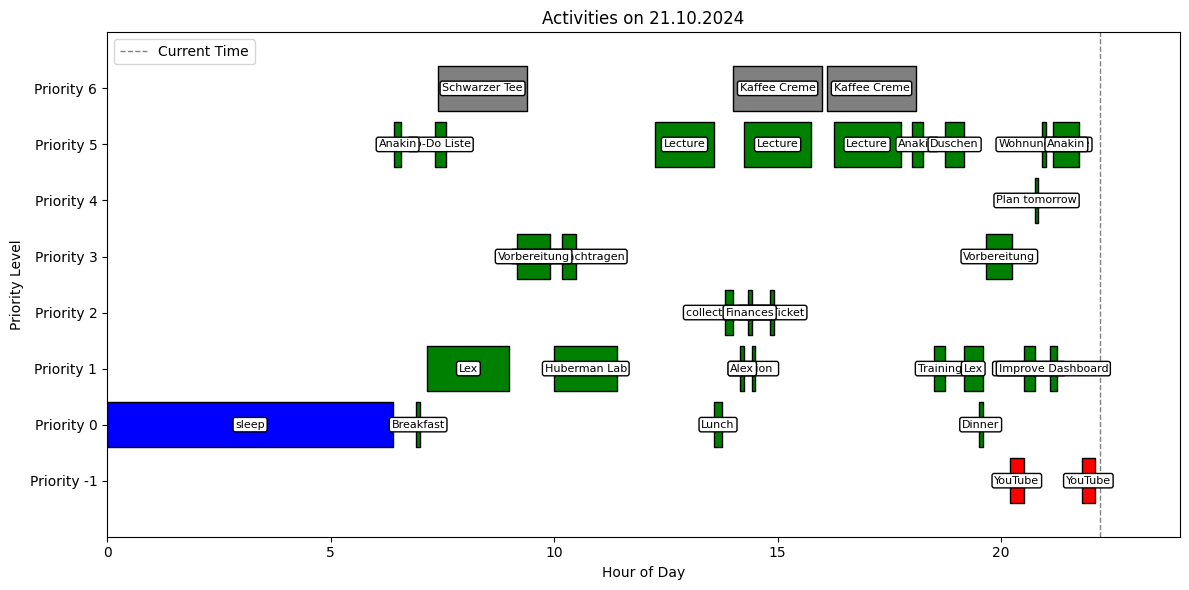

In [21]:
#!pip install openpyxl
import os
import pandas as pd
from datetime import date, timedelta, datetime, timezone, time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import pytz
import re

warnings.filterwarnings('ignore')

# File paths and configurations
desktop_path = os.path.expanduser('~')
filename = os.path.join(desktop_path, 'Desktop', 'Data_10.04.24.xlsx')
encoding_type = 'ISO-8859-1'
sheets = ["sleep", "free_time", "schedule", "caffein"]
dfs = []

# Load and process each sheet
for sheet in sheets:
    df = pd.read_excel(filename, sheet_name=sheet)
    if sheet == "sleep":
        df = df.drop(columns=["Schlafzeit", "Wecker", "Überschlafen", "Sleep_Stop_Plan"], errors='ignore')
    elif sheet == "free_time":
        df = df.drop(columns=["length", "Time"], errors='ignore')
    elif sheet == "schedule":
        df = df.drop(columns=["Comment", "Delay", "one", "two", "three"], errors='ignore')
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df = combined_df.dropna(subset=['Date'])

# Load sleep data from the CSV
filename_sleep = os.path.join(desktop_path, 'Desktop', 'Dektop', 'Sleep Analysis Data 3.csv')
df_sleep = pd.read_csv(filename_sleep, encoding=encoding_type, delimiter=',', on_bad_lines='skip')

# Process df_sleep
one_week_ago = pd.Timestamp.now(tz='UTC') - pd.Timedelta(weeks=1)
df_sleep['Start'] = pd.to_datetime(df_sleep['Start'], utc=True)
df_sleep['End'] = pd.to_datetime(df_sleep['End'], utc=True)
df_sleep = df_sleep[df_sleep['Start'] >= one_week_ago]
df_sleep.rename(columns={'End': 'stop', 'Start': 'start', 'Value': 'Activity'}, inplace=True)
df_sleep = df_sleep[df_sleep['Source'] == 'AppleÂ Watch von Christian']
df_sleep['Priority'] = 0
df_sleep['Category'] = 'sleep'
df_sleep['Comment'] = ''
df_sleep['Adj. Priority'] = 0
df_sleep['Estimate'] = 60
df_sleep['duration'] = (df_sleep['stop'] - df_sleep['start']).dt.total_seconds() / 60

# Assign colors based on activity
conditions = [
    (df_sleep['Activity'] == 'Deep'),
    (df_sleep['Activity'] == 'Core'),
    (df_sleep['Activity'] == 'Light'),
    (df_sleep['Activity'] == 'REM')
]
choices = ['navy', 'lightsteelblue', 'steelblue', 'red']
df_sleep['color'] = np.select(conditions, choices, default='')

# Drop rows without color and unnecessary columns
df_sleep = df_sleep[df_sleep['color'] != '']
df_sleep.drop(columns=['Duration (hr)', 'Source'], inplace=True, errors='ignore')
df_sleep['Date'] = df_sleep['start'].dt.date
df_sleep = df_sleep[~df_sleep['Activity'].isin(['InBed', 'Asleep'])]

# File paths for calendars
file_path_schule = os.path.join(desktop_path, 'Desktop', 'Dektop', 'Calenders', 'Schule_Events.csv')
file_path_arbeit = os.path.join(desktop_path, 'Desktop', 'Dektop', 'Calenders', 'Arbeit_Events.csv')
file_path_dashboard = os.path.join(desktop_path, 'Desktop', 'Dektop', 'Calenders', 'Dashboard_Events.csv')

# Read calendar CSV files
df_schule = pd.read_csv(file_path_schule, encoding=encoding_type, delimiter=',', on_bad_lines='skip')
df_arbeit = pd.read_csv(file_path_arbeit, encoding=encoding_type, delimiter=',', on_bad_lines='skip')
df_dashboard = pd.read_csv(file_path_dashboard, encoding=encoding_type, delimiter=',', on_bad_lines='skip')

# Assign additional attributes
df_schule['type'] = 'Schule'
df_arbeit['type'] = 'Arbeit'
df_dashboard['type'] = 'Dashboard'
df_schule['Priority'] = 5
df_arbeit['Priority'] = 4
df_dashboard['Priority'] = 3

# Combine calendar data
df_cals = pd.concat([df_schule, df_arbeit, df_dashboard], ignore_index=True)

# Specify the correct format for your date columns
date_format = "%d.%m.%y %H:%M:%S"

# Convert 'Start Date' and 'End Date' columns to datetime, specifying the correct format
df_cals['Start Date'] = pd.to_datetime(df_cals['Start Date'], format=date_format, errors='coerce', dayfirst=True)
df_cals['End Date'] = pd.to_datetime(df_cals['End Date'], format=date_format, errors='coerce', dayfirst=True)

# Remove rows where date conversion failed
df_cals = df_cals.dropna(subset=['Start Date', 'End Date'])

# Rename columns for further processing
df_cals.rename(columns={'Summary': 'Activity', 'Start Date': 'start', 'End Date': 'stop'}, inplace=True)

# Further processing for plotting
df_cals['Estimate'] = (df_cals['stop'] - df_cals['start']).dt.total_seconds() / 60
df_cals['Adj. Priority'] = df_cals.apply(lambda x: (x['Priority'] / x['Estimate'] * 60) if x['Estimate'] != 0 else 0, axis=1)
df_cals['Date'] = df_cals['start'].dt.date

# Combine everything
combined_df_e_c = pd.concat([combined_df, df_cals, df_sleep], ignore_index=True)
combined_df_e_c['Date'] = pd.to_datetime(combined_df_e_c['Date'], errors='coerce')

# Ensure 'start' and 'stop' columns are in datetime format
combined_df_e_c['start'] = pd.to_datetime(combined_df_e_c['start'], errors='coerce', utc=True)
combined_df_e_c['stop'] = pd.to_datetime(combined_df_e_c['stop'], errors='coerce', utc=True)

# Ensure 'duration' column exists and is numeric
combined_df_e_c['duration'] = pd.to_numeric(combined_df_e_c['duration'], errors='coerce').fillna(0)

# Filter for today and yesterday
today = date.today()
yesterday = today - timedelta(days=1)
df_today = combined_df_e_c[
    (combined_df_e_c['start'].dt.date <= today) & 
    (combined_df_e_c['stop'].dt.date >= today)
]
df_yesterday = combined_df_e_c[
    (combined_df_e_c['start'].dt.date <= yesterday) & 
    (combined_df_e_c['stop'].dt.date >= yesterday)
]

# Filter today's tasks into done and not done
df_today_done = df_today[df_today['duration'] > 0]
df_today_not_done = df_today[df_today['duration'] <= 0]

# Define the schedule_tasks function
def schedule_tasks(df_events, df_tasks):
    now = datetime.now(timezone.utc)
    today = now.date()

    # Ensure 'start' and 'stop' in df_events are timezone-aware (UTC)
    df_events['start'] = pd.to_datetime(df_events['start'], utc=True)
    df_events['stop'] = pd.to_datetime(df_events['stop'], utc=True)

    # Filter future events occurring today and after the current time
    future_events = df_events[(df_events['start'].dt.date == today) & (df_events['start'] > now)]

    scheduled_tasks = []
    occupied_slots = []

    # Track all occupied time slots
    for _, event in future_events.iterrows():
        occupied_slots.append((event['start'], event['stop']))

    # Sort tasks by 'Adj. Priority' in descending order (higher priority first)
    df_tasks = df_tasks.sort_values(by='Adj. Priority', ascending=False)

    for _, task in df_tasks.iterrows():
        start_time = now
        end_time = start_time + timedelta(minutes=task['Estimate'])

        # Check if the task's time conflicts with any occupied time slots
        for occupied_start, occupied_stop in occupied_slots:
            if start_time < occupied_stop + timedelta(minutes=10):
                start_time = occupied_stop + timedelta(minutes=10)
                end_time = start_time + timedelta(minutes=task['Estimate'])

        # Create the task's scheduled entry
        scheduled_task = task.to_dict()
        scheduled_task['start'] = start_time
        scheduled_task['stop'] = end_time
        scheduled_task['color'] = 'yellow'
        scheduled_task['type'] = 'auto_planned'
        scheduled_task['duration'] = scheduled_task['Estimate']

        # Append the task to the list of scheduled tasks
        scheduled_tasks.append(scheduled_task)

        # Update 'now' and add the task to occupied slots
        now = end_time + timedelta(minutes=10)
        occupied_slots.append((start_time, end_time))

    return pd.DataFrame(scheduled_tasks)

# Schedule today's not done tasks
scheduled_tasks_df = schedule_tasks(combined_df_e_c, df_today_not_done)

# Processing for plotting
plot_today = pd.concat([df_today_done, scheduled_tasks_df], ignore_index=True)

# Ensure necessary columns exist in plot_today
required_columns = ['Priority', 'duration', 'start', 'stop', 'Activity', 'color', 'Category', 'done']
for col in required_columns:
    if col not in plot_today.columns:
        plot_today[col] = np.nan

# Fill missing values with defaults
plot_today['Priority'] = plot_today['Priority'].fillna(0)
plot_today['duration'] = plot_today['duration'].fillna(0)
plot_today['color'] = plot_today['color'].fillna('grey')
plot_today['Category'] = plot_today['Category'].fillna('')
plot_today['done'] = plot_today['done'].fillna(0)

# Set display options and print plot data
pd.set_option('display.max_rows', None)
plot_today['start'] = pd.to_datetime(plot_today['start'], utc=True)
plot_today['stop'] = pd.to_datetime(plot_today['stop'], utc=True)

# Define the plotting function
def plot_activities_of_a_day(df, date_str):
    # Ensure 'start' and 'stop' are in datetime format
    df['start'] = pd.to_datetime(df['start'], utc=True)
    df['stop'] = pd.to_datetime(df['stop'], utc=True)

    # Convert 'date_str' to date
    try:
        date_obj = datetime.strptime(date_str, '%d.%m.%Y').date()
    except ValueError:
        print(f"Incorrect date format for {date_str}. Expected format is 'dd.mm.yyyy'.")
        return

    # Filter data for events overlapping with the specified date
    daily_data = df[
        (df['start'] < pd.Timestamp(date_obj + timedelta(days=1), tz='UTC')) &
        (df['stop'] >= pd.Timestamp(date_obj, tz='UTC'))
    ]

    if daily_data.empty:
        print(f"No data for {date_str}.")
        return

    # Adjust events to fit within the day
    daily_data['adjusted_start'] = daily_data['start'].apply(lambda x: max(x, pd.Timestamp(date_obj, tz='UTC')))
    daily_data['adjusted_stop'] = daily_data['stop'].apply(lambda x: min(x, pd.Timestamp(date_obj + timedelta(days=1), tz='UTC')))
    daily_data['duration'] = (daily_data['adjusted_stop'] - daily_data['adjusted_start']).dt.total_seconds() / 60  # duration in minutes
    daily_data['duration_hours'] = daily_data['duration'] / 60  # duration in hours

    # Prepare plotting space
    fig, ax = plt.subplots(figsize=(12, 6))

    # Prepare priority levels
    priority_levels = np.sort(daily_data['Priority'].unique())
    y_positions = range(len(priority_levels))
    y_labels = [f"Priority {int(p)}" for p in priority_levels]

    # Loop through each priority level and plot activities
    for i, priority in enumerate(priority_levels):
        df_priority = daily_data[daily_data['Priority'] == priority]
        for idx, row in df_priority.iterrows():
            start_time = row['adjusted_start']
            start_hour = (start_time - pd.Timestamp(date_obj, tz='UTC')).total_seconds() / 3600
            duration = row['duration_hours']
            activity = row['Activity']
            color = row.get('color', 'grey')

            if color == 'transparent':
                facecolor = 'none'
                edgecolor = 'black'
            else:
                facecolor = color
                edgecolor = 'black'

            bar = ax.broken_barh(
                [(start_hour, duration)],
                (i - 0.4, 0.8),
                facecolors=facecolor,
                edgecolor=edgecolor,
                linewidth=1
            )

            # Add activity labels
            ax.text(
                start_hour + duration / 2,
                i,
                activity,
                ha='center',
                va='center',
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
            )

    # Set labels and title
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Priority Level')
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_title(f'Activities on {date_str}')

    # Set limits
    ax.set_xlim(0, 24)
    ax.set_ylim(-1, len(priority_levels))

    # Add vertical line for the current time if it's the same day
    current_date = datetime.now().date()
    if date_obj == current_date:
        current_time = datetime.now().astimezone().hour + datetime.now().minute / 60
        ax.axvline(x=current_time, color='grey', linestyle='--', linewidth=1, label='Current Time')

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()

# Plot activities of today
today_str = date.today().strftime('%d.%m.%Y')
plot_activities_of_a_day(plot_today, today_str)